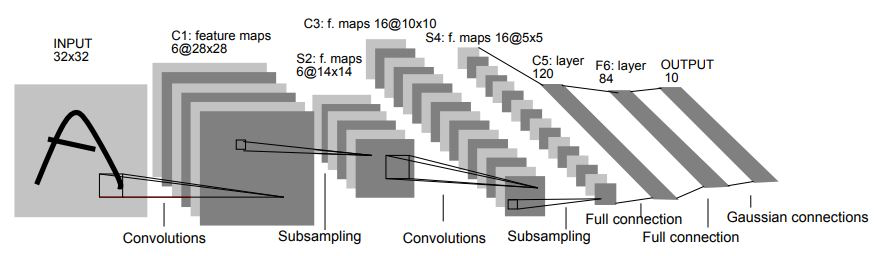

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class TinyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 2, kernel_size=3, bias=True)  # 1×5×5 → 2×3×3
        self.pool = nn.MaxPool2d(kernel_size=3)               # 3×3 → 1×1
        self.fc1  = nn.Linear(2, 3, bias=True)                # 2 → 3
        self.fc2  = nn.Linear(3, 2, bias=True)                # 3 → 2
        self.relu = nn.ReLU()

        # ——— init to your sketch ———
        with torch.no_grad():
            # conv
            self.conv.weight.data[0,0] = torch.tensor([
                [-0.2,  0.2,  0.2],
                [ 0.2,  0.2, -0.2],
                [ 0.2,  0.2, -0.2],
            ])
            self.conv.weight.data[1,0] = torch.tensor([
                [-0.5,  -0.5, 0.5],
                [ 0.5, -0.5,  -0.5],
                [0.5,  0.5,  0.5],
            ])
            self.conv.bias.data.zero_()

            # fc1
            self.fc1.weight.data = torch.tensor([
                [ 0.2, -0.2],
                [-0.2,  0.2],
                [-0.2, -0.2],
            ])
            self.fc1.bias.data.zero_()

            # fc2
            self.fc2.weight.data = torch.tensor([
                [ 0.5, -0.5,  0.5],
                [ 0.5,  0.5,  0.5]
            ])
            self.fc2.bias.data.zero_()

    def forward(self, x):
        # 1) conv pre-activation
        x_conv = self.conv(x)
        x_conv.retain_grad()

        # 2) conv post-ReLU
        x_relu = self.relu(x_conv)
        x_relu.retain_grad()

        # 3) pooling
        x_pool = self.pool(x_relu)
        x_pool.retain_grad()

        # 4) flatten
        x_flat = x_pool.view(x_pool.size(0), -1)
        x_flat.retain_grad()

        # 5) fc1 pre-activation
        x_fc1_pre = self.fc1(x_flat)
        x_fc1_pre.retain_grad()

        # 6) fc1 post-ReLU
        x_fc1 = self.relu(x_fc1_pre)
        x_fc1.retain_grad()

        # 7) logits
        x_fc2 = self.fc2(x_fc1)
        x_fc2.retain_grad()

        # store for gradient inspection
        self.activations = {
            'conv_pre':    x_conv,
            'conv_post':   x_relu,
            'pool':        x_pool,
            'flatten':     x_flat,
            'fc1_pre':     x_fc1_pre,
            'fc1_post':    x_fc1,
            'logits':      x_fc2,
        }

        # print activations as before
        print("After conv (2×3×3):\n", x_conv.detach().numpy())
        print("After ReLU:\n", x_relu.detach().numpy())
        print("After pool (2×1×1):\n", x_pool.detach().numpy())
        print("After flatten (1×2):\n", x_flat.detach().numpy())
        print("FC1 pre-activation (1×3):\n", x_fc1_pre.detach().numpy())
        print("FC1 post-ReLU:\n", x_fc1.detach().numpy())
        print("Logits (1×2):\n", x_fc2.detach().numpy())
        print("Softmax probs:\n",
              nn.functional.softmax(x_fc2, dim=1).detach().numpy())

        return x_fc2

# — set up
model     = TinyConvNet()
criterion = nn.CrossEntropyLoss()
opt       = optim.SGD(model.parameters(), lr=1)

print("=== Starting parameters ===")
print("Conv0:\n", model.conv.weight.data[0,0])
print("Conv1:\n", model.conv.weight.data[1,0])
print("FC1:\n", model.fc1.weight.data)
print("FC2:\n", model.fc2.weight.data)
print("———————————————\n")

# one sample
inp = torch.tensor([[[
    [1,1,1,1,1],
    [1,0,0,0,1],
    [1,1,1,1,1],
    [1,0,0,0,1],
    [1,0,0,0,1],
]]], dtype=torch.float32)
target = torch.tensor([0])

# forward → backward
print("=== Iteration 0: forward/backward ===")
out   = model(inp)
loss  = criterion(out, target)
loss.backward()
print(f"loss = {loss}")

# print gradients on activations
print("\n=== Gradients of every intermediate activation ===")
for name, tensor in model.activations.items():
    print(f"{name}.grad =\n", tensor.grad)

# step and show updated weights
opt.step()
print("\n=== After SGD step ===")
print("FC2 weights:\n", model.fc2.weight.data)
print("FC1 weights:\n", model.fc1.weight.data)
print("Conv filters unchanged (zero δ):\n", model.conv.weight.data)


=== Starting parameters ===
Conv0:
 tensor([[-0.2000,  0.2000,  0.2000],
        [ 0.2000,  0.2000, -0.2000],
        [ 0.2000,  0.2000, -0.2000]])
Conv1:
 tensor([[-0.5000, -0.5000,  0.5000],
        [ 0.5000, -0.5000, -0.5000],
        [ 0.5000,  0.5000,  0.5000]])
FC1:
 tensor([[ 0.2000, -0.2000],
        [-0.2000,  0.2000],
        [-0.2000, -0.2000]])
FC2:
 tensor([[ 0.5000, -0.5000,  0.5000],
        [ 0.5000,  0.5000,  0.5000]])
———————————————

=== Iteration 0: forward/backward ===
After conv (2×3×3):
 [[[[ 0.6         0.40000004  0.2       ]
   [ 0.2         0.2         0.2       ]
   [ 0.6         0.2        -0.2       ]]

  [[ 1.5         1.          0.5       ]
   [-0.5        -0.5         0.5       ]
   [ 0.5        -0.5        -0.5       ]]]]
After ReLU:
 [[[[0.6        0.40000004 0.2       ]
   [0.2        0.2        0.2       ]
   [0.6        0.2        0.        ]]

  [[1.5        1.         0.5       ]
   [0.         0.         0.5       ]
   [0.5        0.         0.